In [1]:
import numpy as np
import pandas as pd
import itertools
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import math
import statsmodels.api as sm
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

**Fetching the data**

In [2]:
sales=pd.read_excel('./data/Armen Living 2023 Sales.xlsx')
item_ref=pd.read_excel('./data/Item Cross References CHRIS 2023-10-30T15_58_34.xlsx')
item_list=pd.read_excel('./data/Item List CHRIS 2023-10-30T15_55_16.xlsx')

In [3]:
## inventory
sales.head(3)

,Document No.,Line No.,Sell-to Customer No.,No.,Location Code,Description,Quantity,Unit Price,Amount,Blanket Order No.,Unit Cost,Posting Date,Cross-Reference No.,Item Category Code
0,639059,10000,A701,LCDH3GREY,VL,MW-1813 DELILAH SOFA DK GR,1.0,1032.0,1032.0,NaN,230.040,2023-01-03,B087LWRJMV,LC SOFA
1,639060,10000,A701,LCDH3GREY,VL,MW-1813 DELILAH SOFA DK GR,1.0,1032.0,1032.0,NaN,230.040,2023-01-03,B087LWRJMV,LC SOFA
2,639061,10000,A701,LCBRDIGLTO,VL,JA1445 BRAVO DINING TABLE TOP,1.0,563.0,563.0,NaN,19.855,2023-01-03,B015ETLWNA,LC DINING TABLES


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59801 entries, 0 to 59800
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Document No.          59801 non-null  int64  
 1   Line No.              59801 non-null  int64  
 2   Sell-to Customer No.  59801 non-null  object 
 3   No.                   59801 non-null  object 
 4   Location Code         59801 non-null  object 
 5   Description           59801 non-null  object 
 6   Quantity              59801 non-null  float64
 7   Unit Price            59801 non-null  float64
 8   Amount                59801 non-null  float64
 9   Blanket Order No.     0 non-null      float64
 10  Unit Cost             59801 non-null  float64
 11  Posting Date          59801 non-null  object 
 12  Cross-Reference No.   51038 non-null  object 
 13  Item Category Code    58500 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 6.4+ MB


In [5]:
item_ref.head(3)

,Cross-Reference No.,Item No.,Unique UPC,Cross-Reference No. 2,Variant Code,Unit of Measure,Item Description,Discontinue Bar Code,Description,Quantity on Hand,...,On Hand Available,Qty on KY,Qty on UT,Qty on NH,Inventory on NJ,Inventory on UK,Inventory on CA2,Wayfair 846 Qty,Expected Receipt Date,846 Item No.
0,LC0845BEBL,LC0845BEBL,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BLAC,0,NaN,99,...,97,0,0,0,0,0,0,97,NaT,NaN
1,LC0845BEBR,LC0845BEBR,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BROW,0,NaN,0,...,0,0,0,0,0,0,0,0,NaT,NaN
2,LC0845BEGR,LC0845BEGR,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS GRAY,0,NaN,0,...,0,0,0,0,0,0,0,0,NaT,NaN


In [6]:
item_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Cross-Reference No.    4437 non-null   object        
 1   Item No.               4437 non-null   object        
 2   Unique UPC             0 non-null      float64       
 3   Cross-Reference No. 2  4436 non-null   object        
 4   Variant Code           0 non-null      float64       
 5   Unit of Measure        4402 non-null   object        
 6   Item Description       4437 non-null   object        
 7   Discontinue Bar Code   4437 non-null   int64         
 8   Description            0 non-null      float64       
 9   Quantity on Hand       4437 non-null   int64         
 10  Qty. on Purch. Order   4437 non-null   int64         
 11  Qty. on Sales Order    4437 non-null   int64         
 12  On Hand Available      4437 non-null   int64         
 13  Qty

In [7]:
item_list.head(3)

,No.,Description,Description 2,Quantity OH - VL,Quantity OH - LA10,Quantity on Hand,Qty. on Sales Order,Qty. on Purch. Order,Qty. on Purch. Qoute,Base Unit of Measure,Unit Price,Vendor No.,Item Category Code,Qty. on Asm. Component,Available to Make\n-VL
0,==LC9793SB,979lc SOFA LEATHER SADDLE,BROWN TX106,0,0,0,0,0,0,PCS,750.0,STYLUTION,ZZ,0,0
1,==LC9951CO,995 CHAIR LEATHER COGNAC,DM717,0,0,0,0,0,0,PCS,450.0,STYLUTION,ZZ,0,0
2,==LC9951SB,995 CHAIR LEATHER SADDLE,BROWN TX106,0,0,0,0,0,0,PCS,450.0,STYLUTION,ZZ,0,0


In [8]:
item_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14627 entries, 0 to 14626
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   No.                     14627 non-null  object 
 1   Description             12653 non-null  object 
 2   Description 2           8830 non-null   object 
 3   Quantity OH - VL        14627 non-null  int64  
 4   Quantity OH - LA10      14627 non-null  int64  
 5   Quantity on Hand        14627 non-null  int64  
 6   Qty. on Sales Order     14627 non-null  int64  
 7   Qty. on Purch. Order    14627 non-null  int64  
 8   Qty. on Purch. Qoute    14627 non-null  int64  
 9   Base Unit of Measure    14561 non-null  object 
 10  Unit Price              14627 non-null  float64
 11  Vendor No.              14518 non-null  object 
 12  Item Category Code      14622 non-null  object 
 13  Qty. on Asm. Component  14627 non-null  int64  
 14  Available to Make
-VL   14627 non-null

In [9]:
def clean_number(df, my_column):
    df[my_column] = df[my_column].str.replace('==', '')


item_ref = item_ref.rename({
          'Item No.':'No.'
        }, axis='columns')

clean_number(item_list,'No.')
clean_number(item_ref,'No.')
clean_number(sales,'No.')   

In [10]:
item = pd.merge(item_ref,item_list, on="No.") 
df = pd.merge(item,sales, on="No.") 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58475 entries, 0 to 58474
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Cross-Reference No._x   58475 non-null  object        
 1   No.                     58475 non-null  object        
 2   Unique UPC              0 non-null      float64       
 3   Cross-Reference No. 2   58463 non-null  object        
 4   Variant Code            0 non-null      float64       
 5   Unit of Measure         58169 non-null  object        
 6   Item Description        58475 non-null  object        
 7   Discontinue Bar Code    58475 non-null  int64         
 8   Description_x           0 non-null      float64       
 9   Quantity on Hand_x      58475 non-null  int64         
 10  Qty. on Purch. Order_x  58475 non-null  int64         
 11  Qty. on Sales Order_x   58475 non-null  int64         
 12  On Hand Available       58475 non-null  int64 

In [12]:
df.describe()

,Unique UPC,Variant Code,Discontinue Bar Code,Description_x,Quantity on Hand_x,Qty. on Purch. Order_x,Qty. on Sales Order_x,On Hand Available,Qty on KY,Qty on UT,...,Unit Price_x,Qty. on Asm. Component,Available to Make\n-VL,Document No.,Line No.,Quantity,Unit Price_y,Amount,Blanket Order No.,Unit Cost
count,0.0,0.0,58475.0,0.0,58475.000000,58475.000000,58475.000000,58475.000000,58475.000000,58475.000000,...,58475.000000,58475.000000,58475.000000,58475.000000,5.847500e+04,58475.000000,58475.000000,58475.000000,0.0,58475.000000
mean,NaN,NaN,0.0,NaN,157.047114,64.525849,32.460214,92.725900,0.001590,-0.008739,...,169.934245,0.095733,0.477606,670511.055391,4.549814e+04,2.262762,208.517136,364.610598,NaN,67.228371
std,NaN,NaN,0.0,NaN,260.653050,135.483772,93.619838,143.351735,0.064445,0.093073,...,240.584254,1.339950,3.764226,17686.478608,1.078681e+05,2.973408,288.324458,474.893638,NaN,80.596087
min,NaN,NaN,0.0,NaN,-2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,639059.000000,2.500000e+03,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,0.0,NaN,14.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,86.000000,0.000000,0.000000,655181.000000,1.000000e+04,1.000000,95.000000,131.000000,NaN,34.600000
50%,NaN,NaN,0.0,NaN,68.000000,0.000000,5.000000,37.000000,0.000000,0.000000,...,100.000000,0.000000,0.000000,670955.000000,1.000000e+04,1.000000,128.000000,230.060000,NaN,40.820000
75%,NaN,NaN,0.0,NaN,175.000000,75.000000,23.000000,107.000000,0.000000,0.000000,...,145.000000,0.000000,0.000000,686089.500000,2.000000e+04,3.000000,195.125000,421.725000,NaN,65.000000
max,NaN,NaN,0.0,NaN,1698.000000,966.000000,740.000000,780.000000,3.000000,0.000000,...,2611.000000,88.000000,68.000000,699831.000000,1.450000e+06,118.000000,4065.280000,18727.000000,NaN,1139.000000


In [14]:
df.head(3)

,Cross-Reference No._x,No.,Unique UPC,Cross-Reference No. 2,Variant Code,Unit of Measure,Item Description,Discontinue Bar Code,Description_x,Quantity on Hand_x,...,Location Code,Description,Quantity,Unit Price_y,Amount,Blanket Order No.,Unit Cost,Posting Date,Cross-Reference No._y,Item Category Code_y
0,LC0845BEBL,LC0845BEBL,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BLAC,0,NaN,99,...,VL,0845 CHATHAM BENCH W/ARMS BLAC,1.0,139.0,132.05,NaN,56.48,2023-06-16,LC0845BEBL,LC OTTOBEN
1,LC0845BEBL,LC0845BEBL,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BLAC,0,NaN,99,...,VL,0845 CHATHAM BENCH W/ARMS BLAC,1.0,141.0,121.00,NaN,56.48,2023-06-29,NaN,LC OTTOBEN
2,LC0845BEBL,LC0845BEBL,NaN,ACTIVE,NaN,PCS,0845 CHATHAM BENCH W/ARMS BLAC,0,NaN,99,...,VL,0845 CHATHAM BENCH W/ARMS BLAC,0.0,141.0,0.00,NaN,56.48,2023-06-29,NaN,LC OTTOBEN


In [13]:
df['Unit Price_x']

0        136.0
1        136.0
2        136.0
3        136.0
4        136.0
         ...  
58470    452.0
58471    452.0
58472    530.0
58473    502.0
58474    508.0
Name: Unit Price_x, Length: 58475, dtype: float64

In [111]:
df.isnull().sum()

Cross-Reference No._x         0
No.                           0
Unique UPC                58475
Cross-Reference No. 2        12
Variant Code              58475
Unit of Measure             306
Item Description              0
Discontinue Bar Code          0
Description_x             58475
Quantity on Hand_x            0
Qty. on Purch. Order_x        0
Qty. on Sales Order_x         0
On Hand Available             0
Qty on KY                     0
Qty on UT                     0
Qty on NH                     0
Inventory on NJ               0
Inventory on UK               0
Inventory on CA2              0
Wayfair 846 Qty               0
Expected Receipt Date     34692
846 Item No.              58210
Description_y                 0
Description 2                92
Quantity OH - VL              0
Quantity OH - LA10            0
Quantity on Hand_y            0
Qty. on Sales Order_y         0
Qty. on Purch. Order_y        0
Qty. on Purch. Qoute          0
Base Unit of Measure          0
Unit Pri

In [112]:
df['Posting Date'] = pd.to_datetime(df['Posting Date'])
df['Posting Date']

0       2023-06-16
1       2023-06-29
2       2023-06-29
3       2023-07-24
4       2023-07-25
           ...    
58470   2023-05-11
58471   2023-05-19
58472   2023-10-17
58473   2023-04-28
58474   2023-02-14
Name: Posting Date, Length: 58475, dtype: datetime64[ns]

In [113]:
print('Min date from dataset: %s' % df['Posting Date'].min().date())
print('Max date from dataset: %s' % df['Posting Date'].max().date())

Min date from dataset: 2023-01-03
Max date from dataset: 2023-10-27


In [114]:
df['Year'] = df['Posting Date'].dt.year 
df['Month'] = df['Posting Date'].dt.month
df['Week'] = df['Posting Date'].dt.week 

In [115]:
monthly_sales = df.groupby('Month', as_index=False)['Quantity'].sum()
daily_sales = df.groupby('Posting Date', as_index=False)['Quantity'].sum()
Weekly_sales = df.groupby('Week', as_index=False)['Quantity'].sum()

Text(0, 0.5, 'Quantity')

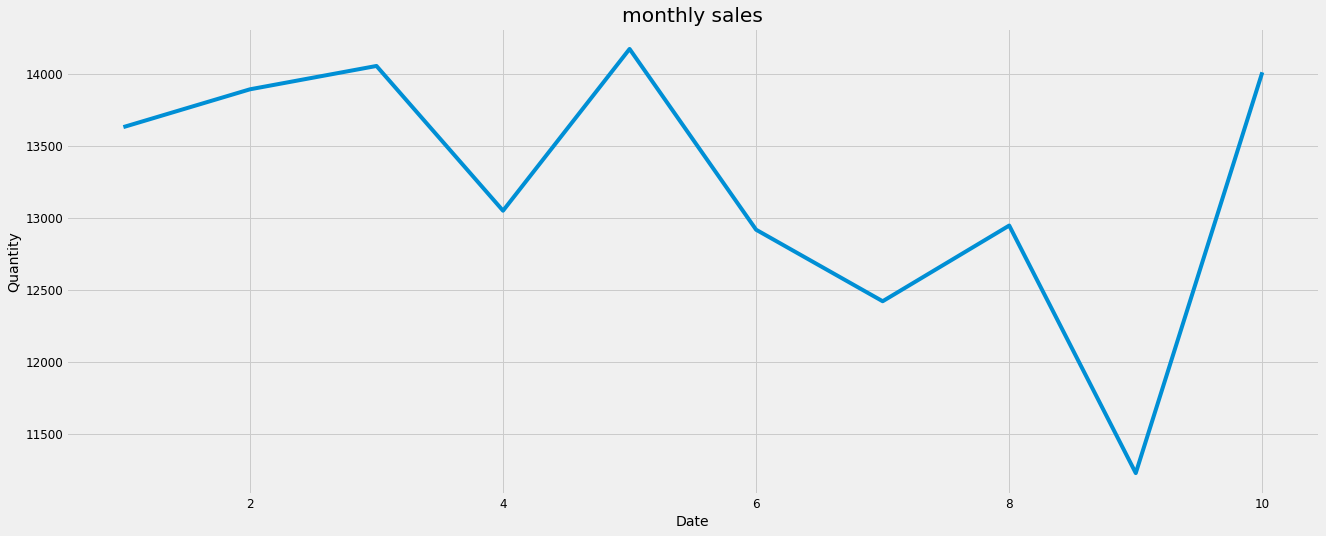

In [116]:
plt.figure(figsize=(20, 8))
plt.plot(monthly_sales['Month'], monthly_sales['Quantity'])
plt.title('monthly sales')
plt.xlabel('Date')
plt.ylabel('Quantity')

Text(0, 0.5, 'Quantity')

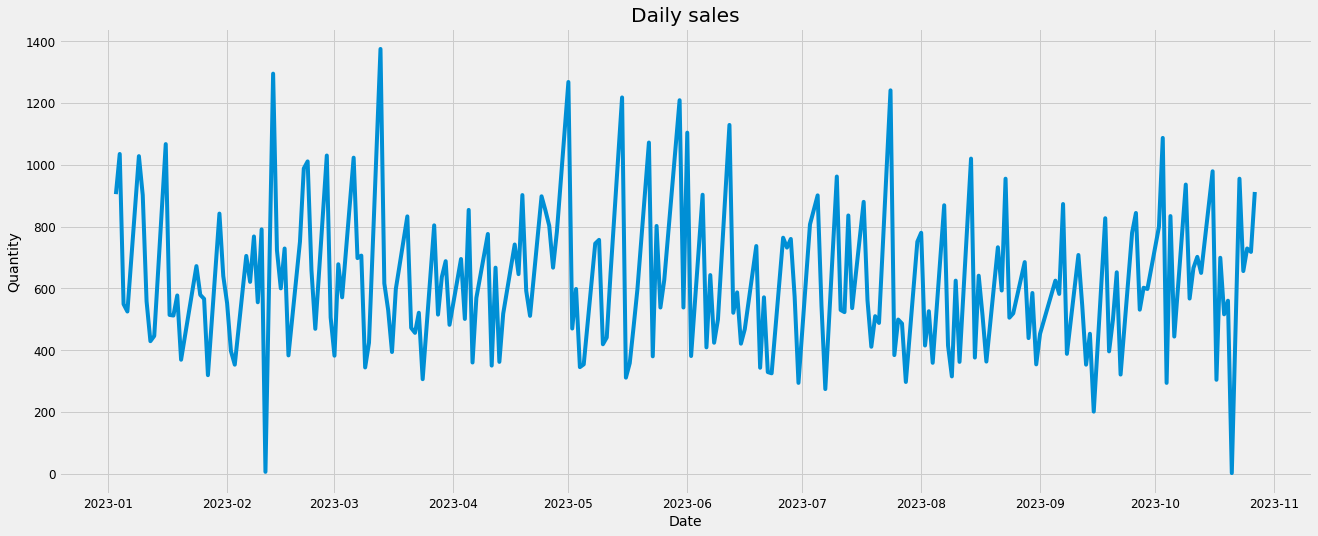

In [117]:
plt.figure(figsize=(20, 8))
plt.plot(daily_sales['Posting Date'], daily_sales['Quantity'])
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Quantity')

Text(0, 0.5, 'Quantity')

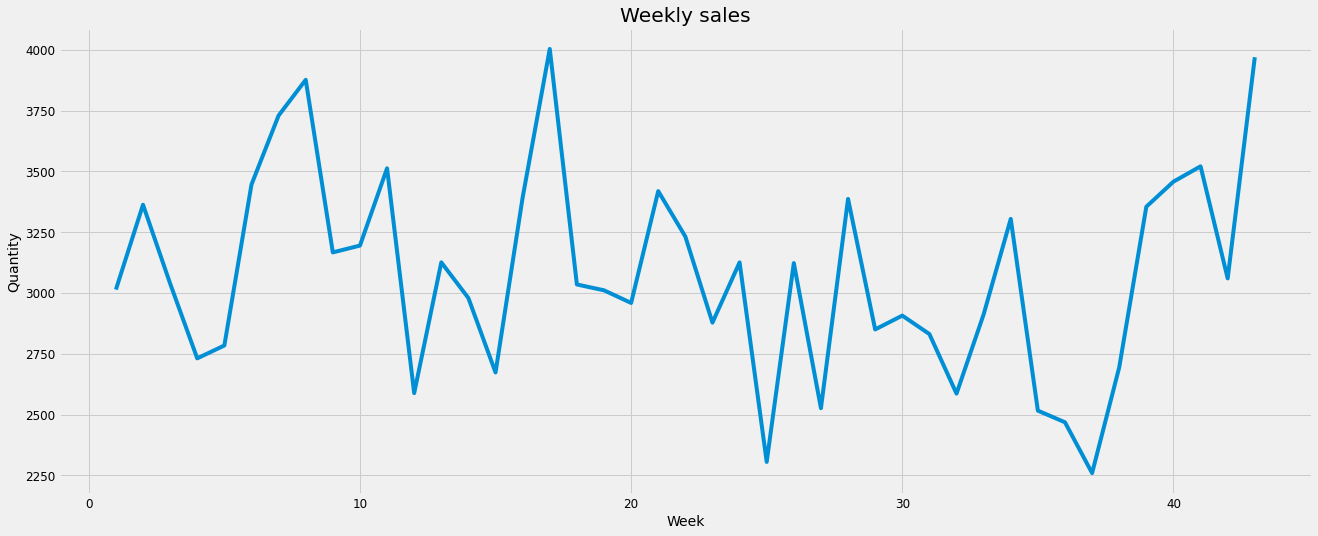

In [118]:
plt.figure(figsize=(20, 8))
plt.plot(Weekly_sales['Week'], Weekly_sales['Quantity'])
plt.title('Weekly sales')
plt.xlabel('Week')
plt.ylabel('Quantity')

**Data preprocessing and cleaning**

**Demand Forecasting**

In [119]:
#df_forcast = df[['No.', 'Posting Date','Year','Month','Week','Quantity','Unit Price_y']]
df_forcast = df[['Posting Date','Quantity']]
df_forcast.head(3)

,Posting Date,Quantity
0,2023-06-16,1.0
1,2023-06-29,1.0
2,2023-06-29,0.0


In [120]:
df_forcast = df_forcast.groupby("Posting Date")['Quantity'].sum().reset_index()
df_forcast.head(3)

,Posting Date,Quantity
0,2023-01-03,905.0
1,2023-01-04,1035.0
2,2023-01-05,549.0


In [121]:
#using the pd to_datetime we convert the order of date format so that python treat date as date not object
df_forcast["Posting Date"] = pd.to_datetime(df_forcast["Posting Date"])
df_forcast.set_index("Posting Date", inplace = True)
df_forcast.index

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-16',
               ...
               '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-21', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27'],
              dtype='datetime64[ns]', name='Posting Date', length=213, freq=None)

In [122]:
df_forcast.head(3)

,Quantity
Posting Date,
2023-01-03,905.0
2023-01-04,1035.0
2023-01-05,549.0


In [123]:
y = df_forcast["Quantity"].resample('MS').mean() #MS mean Month Start
y

Posting Date
2023-01-01    649.000000
2023-02-01    661.476190
2023-03-01    611.000000
2023-04-01    652.450000
2023-05-01    644.136364
2023-06-01    587.136364
2023-07-01    621.050000
2023-08-01    562.869565
2023-09-01    561.450000
2023-10-01    667.095238
Freq: MS, Name: Quantity, dtype: float64

**Visually checking the time series for trend and other components¶**

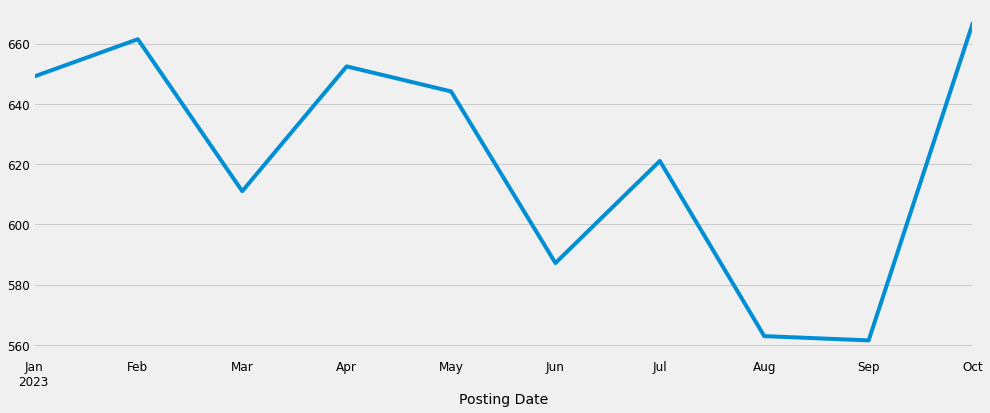

In [124]:
y.plot(figsize=(15,6))
plt.show()

The plot clearly indicates that the time series has seasonality pattern. The sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

**Checking Stationarity**

our first step in time-series analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them. Augmented Dickey-Fuller(ADF) statistic is one of the more widely used statistic test to check whether your time series is stationary or non-stationary. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary(has some time-dependent structure). The alternate hypothesis(rejecting the null hypothesis) is that the time series is stationary.

**Performing the Dicky Fuller Test**

In [125]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)

print("ADF Statistic: %f" % result[0]) #%f means float 
      
print('P-value: %f' % result[1])  
      
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value)) #%.3f means float with 3 decimal point

ADF Statistic: -2.149843
P-value: 0.224950
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901


This suggest that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low propability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In fact, the P-value is not quiet good

**Decomposing**

Decomposing the time series into three distinct components: trend, seasonality,and noise

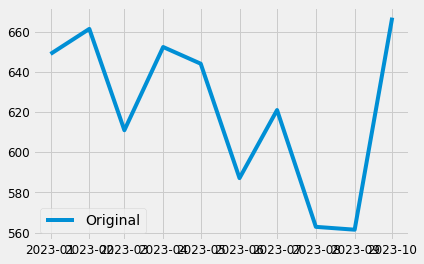

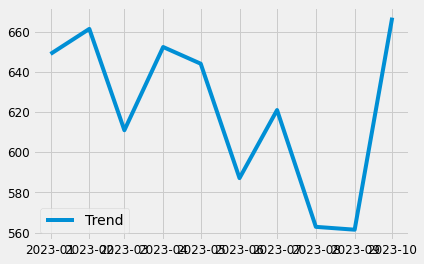

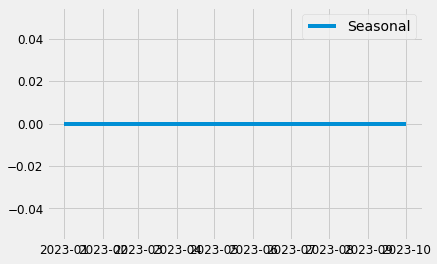

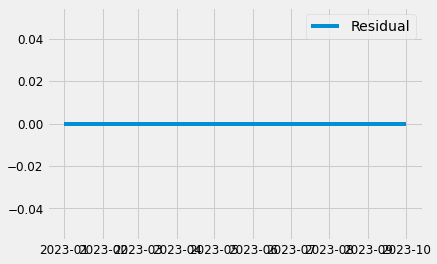

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y,period=1)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')


trend  = decomposition.trend
plt.show()
plt.plot(trend, label = "Trend")
plt.legend(loc  = "best")

seasonal = decomposition.seasonal
plt.show()
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

residual = decomposition.resid
plt.show()
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')


**Forecasting using the best AR I MA(p,d,q) and Seasonality's(P,D,Q)**

Time Series Forecasting using ARIMA. We will use ARIMA for forecasting our time series. ARIMA is also denoted as ARIMA(p,d,q)

In [127]:
p = d = q  = range(0, 2) 
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(X[0], X[1], X[2], 12) for X in list(itertools.product(p, d, q))]
print('Examples of paramter combination for Seasonal ARIMA....')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of paramter combination for Seasonal ARIMA....
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [128]:
from pylab import rcParams #Param means Parameter
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param,
seasonal_order=param_seasonal,
enforce_stationarity=False,
enforce_invertibility= False)
            results = mod.fit()
            print('ARIMA{}x{}12- AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06373D+00    |proj g|=  1.37293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   9.138D-06   7.064D+00
  F =   7.0637193866382404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12- AIC:143.2743877327648
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12- AIC:6.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly a

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point afte

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12- AIC:6.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previ

ARIMA(1, 0, 0)x(1, 1, 1, 12)12- AIC:8.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24694D+00    |proj g|=  5.82829D+00

At iterate    5    f=  4.21572D+00    |proj g|=  1.60304D+00

At iterate   10    f=  4.15682D+00    |proj g|=  1.01710D+00

At iterate   15    f=  4.15640D+00    |proj g|=  2.10767D-02

At iterate   20    f=  4.15620D+00    |proj g|=  4.15300D-01

At iterate   25    f=  4.15288D+00    |proj g|=  8.19154D-01

At iterate   30    f=  4.15220D+00    |proj g|=  4.00943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 0, 0, 12)12- AIC:89.2028970426017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 0, 1, 12)12- AIC:6.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M = 

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequat


At iterate    5    f=  3.71454D+00    |proj g|=  4.60560D-03

At iterate   10    f=  3.69001D+00    |proj g|=  6.43343D-02

At iterate   15    f=  3.67480D+00    |proj g|=  5.65033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   2.405D-06   3.675D+00
  F =   3.6747994069282184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 0, 12)12- AIC:79.49598813856437
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


In [129]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0    

 This problem is unconstrained.


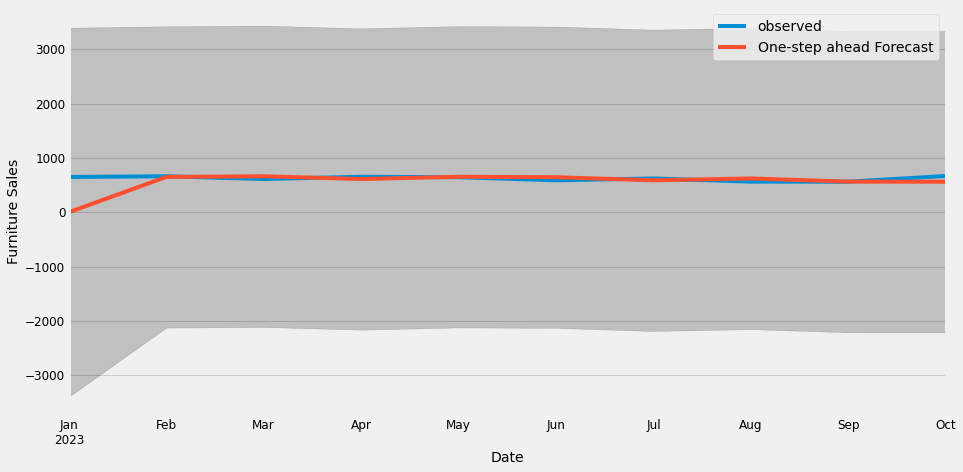

In [135]:
#set forecasts to start at 2023–01–01 to the end of the data to forecast
pred = results.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2023':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',alpha=1, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


In [136]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 210.86


            lower Quantity  upper Quantity
2023-11-01    -2104.713104     3438.903580
2023-12-01    -3252.833711     4587.024187
2024-01-01    -3565.886836     5765.410646
2024-02-01    -3553.411057     5777.887248
2024-03-01    -3603.887660     5727.411469
2024-04-01    -3562.438071     5768.861881
2024-05-01    -3570.752119     5760.548656
2024-06-01    -3627.752531     5703.549068
2024-07-01    -3593.839306     5737.463116
2024-08-01    -3652.020153     5679.283093
2024-09-01    -3653.440130     5677.863939
2024-10-01    -3547.795303     5783.509589
2024-11-01    -5576.698932     7812.413218


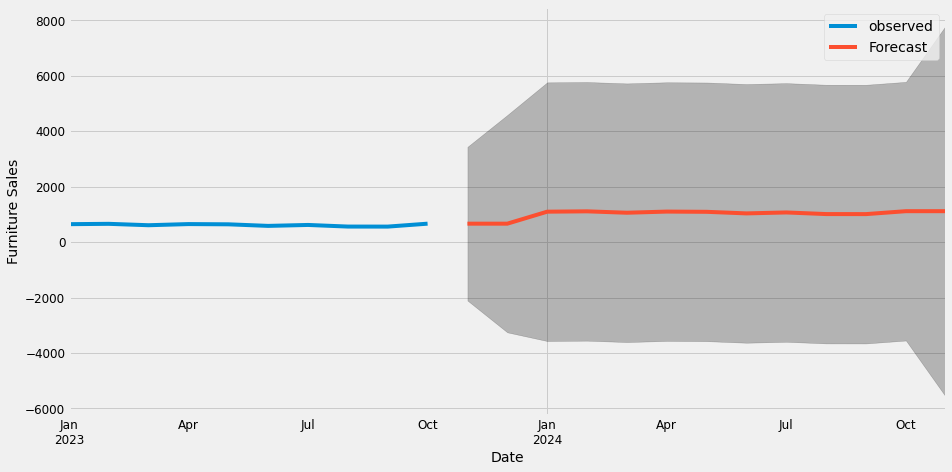

In [137]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
print(pred_ci)
plt.legend()
plt.show()